In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
frames = []
for m in range(1,6):
    temp_df = pd.read_json(f"data/2020/all/f{m}.json",lines=False)
    frames.append(temp_df)
df_all = pd.concat(frames).sort_values(by=['created_at'])
df_all.reset_index(inplace = True,drop=True)

In [3]:
df_all["date"] = df_all.created_at.dt.date
df_all["is_retweet"] = df_all.retweeted_status.notnull()
df_all.drop(columns=["extended_tweet","is_quote_status","retweeted_status"], axis=1,inplace=True)
print(df_all.shape)
df_all.head()

(432309, 27)


,coordinates,created_at,favorite_count,favorited,geo,hashtags,id_str,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,...,reply_count,retweet_count,retweeted,text,urls,user_id_str,user_mentions,username,date,is_retweet
0,None,2020-01-01 00:00:14,43,False,None,,1212161574313615360,None,NaN,NaN,...,1,33,False,"The census is coming in 2020, and it’s almost ...",['https://twitter.com/i/web/status/12121615743...,23092890,,uscensusbureau,2020-01-01,False
1,None,2020-01-01 00:01:03,2,False,None,['2020Census'],1212161777963810816,None,NaN,NaN,...,0,0,False,2019 IN REVIEW: With the #2020Census approachi...,['https://twitter.com/i/web/status/12121617779...,115569615,,EriksonPolicy,2020-01-01,False
2,None,2020-01-01 00:05:07,0,False,None,,1212162802749771776,None,NaN,NaN,...,0,0,False,RT @uscensusbureau: The census is coming in 20...,,27223236,['uscensusbureau'],jimmitchell70,2020-01-01,True
3,None,2020-01-01 00:07:51,0,False,None,['2020Census'],1212163489793499136,None,NaN,NaN,...,0,0,False,RT @hansilowang: 2. As we head into the new ye...,,4364923707,['hansilowang'],u3Y4BDE,2020-01-01,True
4,None,2020-01-01 00:09:00,2,False,None,['2020Census'],1212163778042900480,None,NaN,NaN,...,0,3,False,Both San Diego and Imperial Counties have been...,['https://twitter.com/i/web/status/12121637780...,241196732,['PANASanDiego'],RosenbergFound,2020-01-01,False


## Tweets per day

In [4]:
grouped_2020 = df_all.groupby("date")
grouped_2020=pd.DataFrame({"tweets": grouped_2020["id_str"].count()})
grouped_2020.index = pd.to_datetime(grouped_2020.index)

In [5]:
df_original = df_all[df_all.is_retweet==False ]
grouped_original = df_original.groupby("date")
grouped_original=pd.DataFrame({"tweets": grouped_original["id_str"].count()})
grouped_original.index = pd.to_datetime(grouped_original.index)
print(f"Original tweets {df_original.shape[0]}")

df_retweets = df_all[df_all.is_retweet ]
grouped_retweets = df_retweets.groupby("date")
grouped_retweets=pd.DataFrame({"tweets": grouped_retweets["id_str"].count()})
grouped_retweets.index = pd.to_datetime(grouped_retweets.index)
print(f"Retweets {df_retweets.shape[0]}")

print("\nTotal: ",df_original.shape[0]+df_retweets.shape[0])

Original tweets 134430
Retweets 297879

Total:  432309


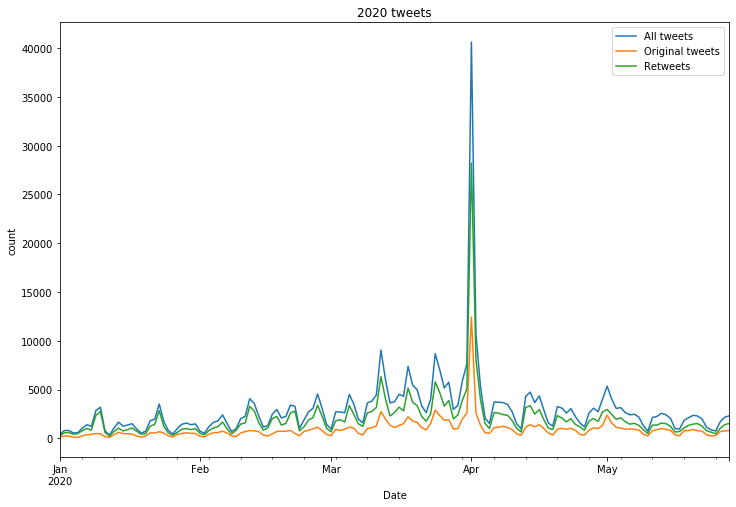

In [6]:
fig,ax = plt.subplots(1,1,figsize=(12,8))
grouped_2020.tweets.plot(label="All tweets",ax = ax)
grouped_original.tweets.plot(label='Original tweets', ax = ax)
grouped_retweets.tweets.plot(label='Retweets', ax = ax)

plt.title("2020 tweets");
plt.ylabel("count")
plt.xlabel("Date");
plt.legend();

### Days with more tweets

In [7]:
print("All tweets:")
print(grouped_2020.sort_values(["tweets"], ascending=False)["tweets"].iloc[:5])

print("\nOriginal tweets:")
print(grouped_original.sort_values(["tweets"], ascending=False)["tweets"].iloc[:5])

All tweets:
date
2020-04-01    40627
2020-04-02    10681
2020-03-12     9058
2020-03-24     8681
2020-03-31     7642
Name: tweets, dtype: int64

Original tweets:
date
2020-04-01    12428
2020-03-24     2899
2020-03-12     2738
2020-04-02     2609
2020-03-31     2579
Name: tweets, dtype: int64


## Most active users


In [72]:
import botometer

rapidapi_key = "8ad33b26a9msh41a64262eec69ebp154c57jsn98e6d9dac767"
twitter_app_auth = {
    'consumer_key': 'Kwl77ioHbYXqSBEuzqEWTbAh0',
    'consumer_secret': 'JPA43yQ2dHzG0NQvAXlBdooBBv39FoEI4j0EylpyGosCyM4mnK',
    'access_token': '500089812-PHGGkFGuQhdzAGfgE5csp9um2mYFHgDwTPDvDfKX',
    'access_token_secret': 'mz4wiZ6HtBDsBUeDFWJcaIMkR53SZM9uVH1p8QEEVspWZ',
  }

def is_bot(accounts,past_results = {}):
    bom = botometer.Botometer(wait_on_ratelimit=True,
                          rapidapi_key=rapidapi_key,
                          **twitter_app_auth)

    r = []
    for account in accounts :       
        if account in past_results:
            r.append(past_results[account]["bot_proba"])
        else :
            result = bom.check_account("@"+account)
            if "cap" not in result:
                r.append(-1)
            else:
                r.append(result["cap"]["english"])
            
    return r

### Original tweets

In [73]:
grouped_u_o = df_original.groupby(df_original['username'])
grouped_u_o =pd.DataFrame({"tweets": grouped_u_o["id_str"].count(),"days": grouped_u_o["date"].nunique()})
grouped_u_o = grouped_u_o.sort_values(by=["tweets"],ascending=False)
grouped_u_o["position"] = np.arange(len(grouped_u_o))+1
grouped_u_o = grouped_u_o[["position","tweets","days"]]
grouped_u_o[:20]

,position,tweets,days
username,,,
hansilowang,1,836,115
uscensusbureau,2,454,126
KansasCounts,3,282,94
LawyersComm,4,273,81
HudsonCensus,5,265,83
SDIDEC,6,247,104
CTCounts2020,7,237,107
TrueNorth_CS,8,222,122
ABNYCensus2020,9,220,82


In [74]:
top_100_o = grouped_u_o[:100]
top_100_o["bot_proba"] = is_bot(list(top_100_o.index))
top_100_o[top_100_o.bot_proba>=0.5]

/home/bernardo/anaconda3/envs/eods-f19/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,position,tweets,days,bot_proba
username,,,,
FOBPL,40,123,59,0.615973
Thewayresource,45,120,18,0.615973
tulsacounts,67,98,46,0.511452


## Retweets

In [75]:
grouped_u_no = df_retweets.groupby(df_retweets['username'])
grouped_u_no =pd.DataFrame({"tweets": grouped_u_no["id_str"].count(),"days": grouped_u_no["date"].nunique()})
grouped_u_no = grouped_u_no.sort_values(by=["tweets"],ascending=False)
grouped_u_no["position"] = np.arange(len(grouped_u_no))+1
grouped_u_no = grouped_u_no[["position","tweets","days"]]
grouped_u_no[:20]

,position,tweets,days
username,,,
CensusPK,1,2337,149
All435Reps,2,1568,145
CountAllKids,3,1351,40
countme2020,4,877,51
KristenGrennan,5,594,110
allthingscensus,6,550,123
HispanicCaucus,7,500,90
census_ie,8,434,88
4americaschild,9,376,9


In [76]:
top_100_no = grouped_u_no[:100]
top_100_no["bot_proba"] = is_bot(list(top_100_no.index),top_100_o[["bot_proba"]].to_dict("index"))
top_100_no[top_100_no.bot_proba>=0.5]

/home/bernardo/anaconda3/envs/eods-f19/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,position,tweets,days,bot_proba
username,,,,
CensusPK,1,2337,149,0.740523
4americaschild,9,376,9,0.565053
GreenWins,49,164,49,0.740523


### All tweets

In [10]:
grouped_u = df_all.groupby(df_all['username'])
grouped_u =pd.DataFrame({"tweets": grouped_u["id_str"].count(),"days": grouped_u["date"].nunique()})
grouped_u = grouped_u.sort_values(by=["tweets"],ascending=False)
grouped_u["position"] = np.arange(len(grouped_u))+1
grouped_u = grouped_u[["position","tweets","days"]]
grouped_u[:20]

,position,tweets,days
username,,,
CensusPK,1,2337,149
All435Reps,2,1568,145
CountAllKids,3,1457,43
countme2020,4,950,69
hansilowang,5,836,115
KristenGrennan,6,609,110
allthingscensus,7,551,123
HispanicCaucus,8,550,95
uscensusbureau,9,487,131


## Language

In [17]:
all_tweets = df_all.shape[0]
undetermined = df_all[df_all.lang=="und"].shape[0]

print("Tweets with undetermined language:",round(undetermined*100/all_tweets,2),"%")
print("Tweets with language determined:",round((1-undetermined/all_tweets)*100,2),"%")

Tweets with undetermined language: 1.42 %
Tweets with language determined: 98.58 %


en       98.207112
es        1.226466
other     0.566422
Name: lang, dtype: float64


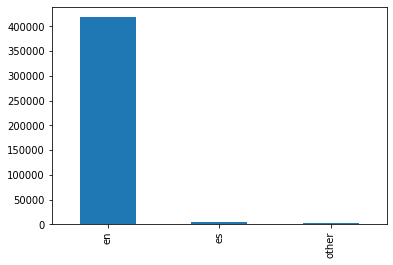

In [28]:
langs = ["en","es"]
langs_count = df_all[df_all.lang!="und"].lang.map(lambda x: x if x in langs else "other").value_counts()
print(langs_count*100/(all_tweets-undetermined))
langs_count.sort_values(ascending=False).plot(kind = 'bar');

## Shared urls

In [6]:
from pyspark.sql import SparkSession

spark= SparkSession.builder.getOrCreate()

rdd_original = spark.createDataFrame(df_original[df_original.urls!=""][["date","urls"]]).rdd
rdd_all = spark.createDataFrame(df_all[df_all.urls!=""][["date","urls"]]).rdd

In [7]:
data_original = rdd_original.map(lambda x: (x[0],x[1].lstrip("[").rstrip("]").lower().split(",")  ))\
.flatMapValues(lambda x: x).map(lambda x: (x[0],x[1].strip("'").strip().rstrip("/")))\
.map(lambda x: ( x[1], [x[0]] )).reduceByKey(lambda x,y: x+y ).map(lambda x: (x[0],len(x[1]),x[1]  ))

data_all = rdd_all.map(lambda x: (x[0],x[1].lstrip("[").rstrip("]").lower().split(",")  ))\
.flatMapValues(lambda x: x).map(lambda x: (x[0],x[1].strip("'").strip().rstrip("/")))\
.map(lambda x: ( x[1], [x[0]] )).reduceByKey(lambda x,y: x+y ).map(lambda x: (x[0],len(x[1]),x[1]  ))

data_original.take(2)

[('https://twitter.com/i/web/status/1212183033622585344',
  1,
  [datetime.date(2020, 1, 1)]),
 ('https://twitter.com/i/web/status/1212199764705644544',
  1,
  [datetime.date(2020, 1, 1)])]

### Original tweets

In [8]:
df_urls = data_original.toDF().toPandas()
df_urls.columns = ["url","count","dates"]
df_urls.sort_values(by="count",ascending=False,inplace=True)
df_urls.reset_index(inplace=True)
df_urls=df_urls[["url","count","dates"]]
df_urls.loc[:50]

,url,count,dates
0,http://my2020census.gov,1658,"[2020-02-06, 2020-02-16, 2020-02-16, 2020-02-2..."
1,http://2020census.gov,1326,"[2020-01-04, 2020-01-14, 2020-01-15, 2020-01-1..."
2,https://my2020census.gov,702,"[2020-03-10, 2020-03-10, 2020-03-10, 2020-03-1..."
3,https://2020census.gov,487,"[2020-01-27, 2020-01-31, 2020-02-01, 2020-02-0..."
4,http://www.2020census.gov,271,"[2020-02-04, 2020-02-05, 2020-02-05, 2020-02-1..."
5,http://www.my2020census.gov,254,"[2020-03-05, 2020-03-11, 2020-03-12, 2020-03-1..."
6,https://2020census.gov/en.html,164,"[2020-01-15, 2020-02-08, 2020-02-17, 2020-02-2..."
7,http://www.census.gov,142,"[2020-01-10, 2020-03-12, 2020-03-17, 2020-03-1..."
8,'https://www.facebook.com/aacps/videos/2308783...,115,"[2020-03-31, 2020-03-31, 2020-03-31, 2020-03-3..."
9,https://2020census.gov/en/response-rates.html,95,"[2020-03-12, 2020-03-18, 2020-03-20, 2020-03-2..."


### All tweets

In [36]:
df_urls_all = data_all.toDF().toPandas()
df_urls_all.columns = ["url","count","dates"]
df_urls_all.sort_values(by="count",ascending=False,inplace=True)
df_urls_all.reset_index(inplace=True)
df_urls_all=df_urls[["url","count","dates"]]
df_urls_all.loc[:50]

,url,count,dates
0,http://my2020census.gov,1658,"[2020-02-06, 2020-02-16, 2020-02-16, 2020-02-2..."
1,http://2020census.gov,1326,"[2020-01-04, 2020-01-14, 2020-01-15, 2020-01-1..."
2,https://my2020census.gov,702,"[2020-03-10, 2020-03-10, 2020-03-10, 2020-03-1..."
3,https://2020census.gov,487,"[2020-01-27, 2020-01-31, 2020-02-01, 2020-02-0..."
4,http://www.2020census.gov,271,"[2020-02-04, 2020-02-05, 2020-02-05, 2020-02-1..."
5,http://www.my2020census.gov,254,"[2020-03-05, 2020-03-11, 2020-03-12, 2020-03-1..."
6,https://2020census.gov/en.html,164,"[2020-01-15, 2020-02-08, 2020-02-17, 2020-02-2..."
7,http://www.census.gov,142,"[2020-01-10, 2020-03-12, 2020-03-17, 2020-03-1..."
8,'https://www.facebook.com/aacps/videos/2308783...,115,"[2020-03-31, 2020-03-31, 2020-03-31, 2020-03-3..."
9,https://2020census.gov/en/response-rates.html,95,"[2020-03-12, 2020-03-18, 2020-03-20, 2020-03-2..."


In [67]:
df_urls_all[df_urls_all.url.str.contains("kansascounts")]

,url,count,dates
644,https://twitter.com/kansascounts/status/125477...,3,"[2020-04-27, 2020-04-27, 2020-04-28]"
817,https://twitter.com/kansascounts/status/124245...,2,"[2020-03-24, 2020-03-24]"
825,https://twitter.com/kansascounts/status/124218...,2,"[2020-03-23, 2020-03-23]"
1446,https://twitter.com/kansascounts/status/122215...,2,"[2020-01-28, 2020-01-28]"
1459,https://twitter.com/kansascounts/status/121312...,2,"[2020-01-03, 2020-01-03]"
9310,https://twitter.com/kansascounts/status/125223...,1,[2020-04-20]
12031,https://twitter.com/kansascounts/status/124538...,1,[2020-04-01]
13780,https://twitter.com/kansascounts/status/125006...,1,[2020-04-14]
13998,https://twitter.com/kansascounts/status/124792...,1,[2020-04-09]
14532,https://twitter.com/kansascounts/status/125042...,1,[2020-04-15]


In [40]:
print(df_all.shape)
df_all[df_all.text.str.lower().str.contains("kansascounts.org")]

(432309, 29)


,coordinates,created_at,extended_tweet,favorite_count,favorited,geo,hashtags,id_str,in_reply_to_screen_name,in_reply_to_status_id,...,reply_count,retweet_count,retweeted,retweeted_status,text,urls,user_id_str,user_mentions,username,date


In [66]:
r = df_all[(df_all.username=="KansasCounts") & (df_all.date.astype(str)=="2020-01-03") ]
for i in range(r.shape[0]):
    print(r.iloc[i].text)
    print(r.iloc[i].urls)

#DYK census data is used to plan the budget for governments at all levels

#KansasCapitol #KansasCounts
#2020Census… https://t.co/ExWpMXJvVw
['https://twitter.com/i/web/status/1213110774329233409']
Kansas is supporting the #2020Census! Check out https://t.co/DtujrQOuqD to find Kansas census materials.… https://t.co/a8lpkD9cwY
['http://www.kansascounts.org', 'https://twitter.com/i/web/status/1213124105668567047']
Why is it important for you to participate in the #2020Census? Watch this video &amp; share the information with your f… https://t.co/jZK1LOTliL
['https://twitter.com/i/web/status/1213124835922137088']
Yes, everyone counts! What are you doing to make sure every Kansan is counted in the #2020Census?
@KansasCounts… https://t.co/pV1QTay6Jo
['https://twitter.com/i/web/status/1213146755040079873']
